# Hackaton 02/20

your team members: Connor Vernachio (me, myself and I)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Task 1

A 1D rod of length $L=1$ has fixed end temperatures $T(0)=0$ and $T(1)=0$. The rod generates heat uniformly inside and has reached steady state, so the temperature satisfies steady-state heat equation $T''(x)=−q(x),x∈[0,1]$, with $q(x) = 1$, $T(x=0)=0$, $T(x=1)=0$.

**Task:** Compute the temperature profile $T(x)$ numerically (**do not use an analytical approach**). You may use **any computational approaches**. Plot the resulting $T(x)$ and briefly explain your method.


You may use external resources (Google, LLMs, etc.), but your proposed solution must be explained and justified. Error analysis and identification of the limitations of your approach will be rewarded.

For this problem we will be using the central difference approximation. Given that this is a second derivative in which the primary equation is linear we can simply express it as dx**2 which makes it pretty simple to solve.

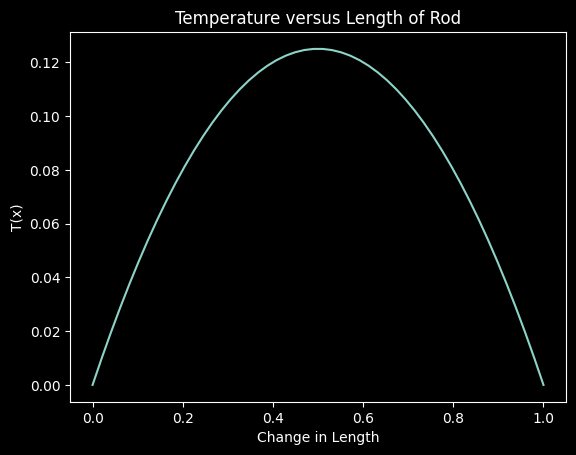

In [2]:
# Develop number of grid points to analyze
L = 1
N= 50

# Change in x across the number of points
dx = L/ (N-1)

# Number of points on the interior, neglecting boundary conditions
n = N-2

# Initialize array to express interior points

A = np.zeros((n,n))

for i in range(n):

    A[i,i] = -2
    if i > 0:
        A[i,i-1]=1
    if i < n-1:
        A[i,i+1] = 1

# Create Vector describing RHS of central difference equation for the 2nd derivative approximation
b = -dx**2 * np.ones(n)

# Utilize np.linalg.solve() to solve the system via LU decomposition. Enforces local energy balance through forward and backward substitution to develop a vector solution.
T_inside= np.linalg.solve(A,b)


# Establish boundary conditions
T = np.zeros(N)
T[1:-1] = T_inside

x = np.linspace(0,1,N)

plt.plot(x,T)
plt.xlabel("Change in Length")
plt.ylabel("T(x)")
plt.title("Temperature versus Length of Rod")



### Task 2

Nonlinear heat conduction. The same rod but now temperature satisfies $T''(x)=-T(x)^3,x∈[0,1]$, $T(0)=0$, $T(1)=0$.

Here we used the Newton-Raphson Method because we can make this a root finding problem now that we can no longer assess it as a linear problem. Thus, we can still use the central approximation as our set-up and keep it set to zero.

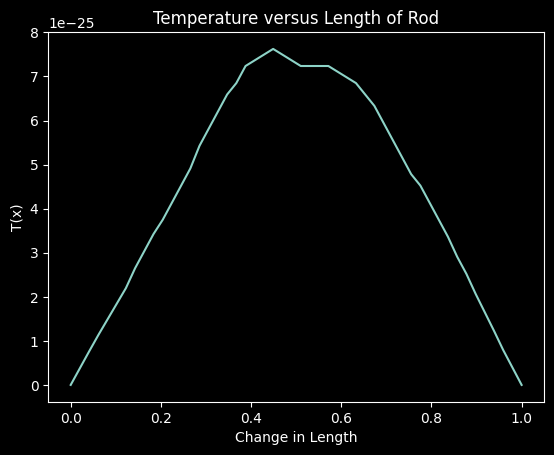

In [3]:
# your code and analysis

# Develop number of grid points to analyze
L_2 = 1
N_2= 50
n_2= N_2-2

T_2 =np.zeros(N_2)
T_2[1:-1] = 0.1

tol = 1e-6
maxiter = 50

# Utilize the Newton-Raphson Method to solve for this nonlinear differential, this will assist in linearizing the equation that way we can use np.linalg.solve() to get a vector solution

for _ in range(maxiter):

    # Build arrays for the function and its derivative
    F= np.zeros(n_2)
    J = np.zeros((n_2,n_2))

    # Iterate across the interior space applying the Newton-Raphson
    for i in range(n_2):

        Ti = T_2[i+1]

        F[i] = (T_2[i+2]-2*Ti+T_2[i]+dx**2*Ti**3)
        J[i,i] = -2+3*dx**2*2*Ti**2

        if i >0:
            J[i,i-1] = 1

        if i < n_2-1:
            J[i,i+1] = 1

    # After linearizing with the Newton-Raphson

    delta = np.linalg.solve(J,-F)
    T_2[1:-1] += delta

    if np.linalg.norm(delta) < tol:
        break

x_2 = np.linspace(0,1,N)

plt.plot(x_2,T_2)
plt.xlabel("Change in Length")
plt.ylabel("T(x)")
plt.title("Temperature versus Length of Rod")

### Task 3

Inverse problem. $T''(x)=-q(x),x∈[0,1]$, $T(x=0)=0$, $T(x=1)=0$.
The temperature is measured in the several points (see below).

**Task:** Can you reconstruct $q(x)$?




In [4]:
# measurement locations
x_meas = np.array([
    0, 0.05, 0.20, 0.30, 0.40,
    0.60, 0.70, 0.80, 0.95, 1
])

# measured temperatures (synthetic data)
T_meas = np.array([
    0,
    0.0228,
    0.0832,
    0.1121,
    0.1336,
    0.1324,
    0.1073,
    0.0704,
    0.0158,
    0,
])

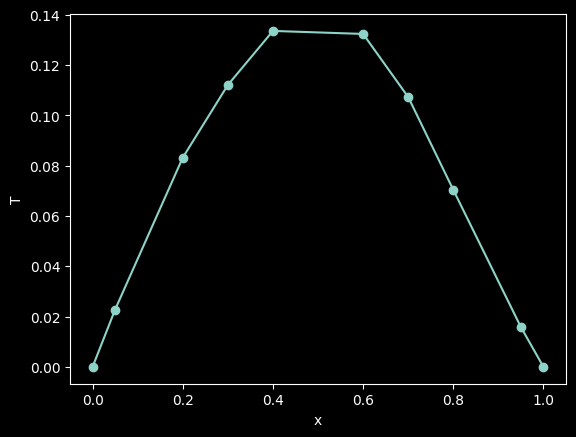

In [5]:
plt.plot(x_meas, T_meas, 'o-')
plt.xlabel('x')
plt.ylabel('T')

In [6]:
import pysr
from pysr import PySRRegressor

model = PySRRegressor( niterations= 150, population_size= 150,
                       binary_operators=["*", "-", "+", "/"], unary_operators= ["square", "exp", "neg", "abs"],
                       elementwise_loss= "f(x,y) = abs(x-y)",
                       complexity_of_operators= {"square": 1, "exp": 1},
                       complexity_of_constants= 1.00,
                       complexity_of_variables= 1.25,
                       maxsize= 12,
                       maxdepth=6,
                       verbosity= True,
                       )

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [7]:
model.fit(x_meas.reshape(-1,1), T_meas)

  - outputs\20260220_200217_6ImkCf\hall_of_fame.csv


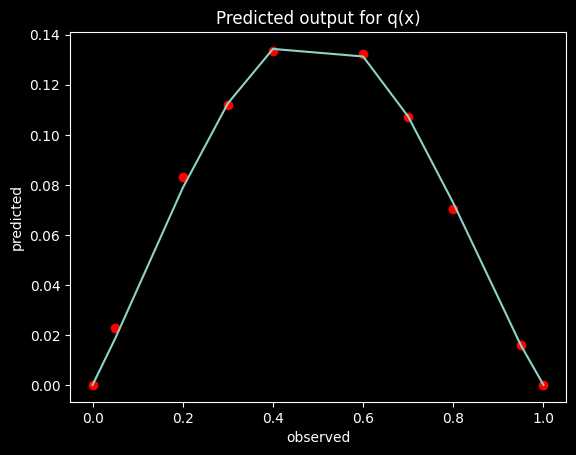

In [9]:
plt.plot(x_meas, T_meas, 'ro')
plt.plot(x_meas, model.predict(x_meas.reshape(-1,1)))
plt.title("Predicted output for q(x)")
plt.xlabel("observed")
plt.ylabel("predicted")

In [10]:
model.equations_

,complexity,loss,equation,score,sympy_format,lambda_format
0,1,0.045960,0.08076287,0.000000,0.0807628700000000,PySRFunction(X=>0.0807628700000000)
1,5,0.044680,(x0 * -0.021333689) + 0.08746684,0.007061,0.08746684 + x0*(-0.021333689),PySRFunction(X=>0.08746684 + x0*(-0.021333689))
2,6,0.004390,(x0 - square(x0)) / 1.873328,2.320143,(-x0**2 + x0)/1.873328,PySRFunction(X=>(-x0**2 + x0)/1.873328)
3,8,0.003858,x0 * abs((x0 + -0.98030996) * 0.54921585),0.064678,x0*(0.54921585*Abs(x0 - 0.98030996)),PySRFunction(X=>x0*(0.54921585*Abs(x0 - 0.9803...
4,10,0.002781,x0 * ((abs(x0 + -0.9898922) * 0.5497025) - 0.0...,0.163555,x0*(Abs(x0 - 0.9898922)*0.5497025 - 1*0.005558...,PySRFunction(X=>x0*(Abs(x0 - 0.9898922)*0.5497...
5,12,0.001338,(x0 - square(x0)) * (0.56443596 - square(0.468...,0.366048,(0.56443596 - (0.46853942 - x0)**2)*(-x0**2 + x0),PySRFunction(X=>(0.56443596 - (0.46853942 - x0...


In [11]:
best_fit = model.equations_["equation"][2]
print(f"The best fit to the model is {best_fit}")

The best fit to the model is (x0 - square(x0)) / 1.873328
